In [1]:
"""Utilities for displaying native-resolution images in iPython Notebook"""

import tempfile

from IPython.core import display

from skimage.io import imread, imsave

def show_image(arr):
    with tempfile.NamedTemporaryFile(suffix='.png') as tf:
        imsave(tf.name, arr)
        return display.Image(filename=tf.name)

def show_mask(arr):
    return show_image((arr>0)*255)

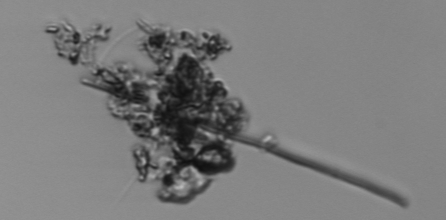

In [2]:
"""Fetch a ROI image from the IFCB Dashboard"""

roi_pid='http://ifcb-data.whoi.edu/mvco/IFCB5_2016_039_055413_02759'

roi_url = '%s.png' % roi_pid

roi = imread(roi_url)

show_image(roi)

Step 1: Use phase congruency to detect edges in the ROI image. Phase congruency is an edge and corner detection technique that works well with variable-contrast edges, which occur in IFCB data for a variety of reasons including objects not being perfectly aligned with the focal plane.

For details on phase congruency see Peter Kovesi's notes on the algorithm:

http://www.peterkovesi.com/projects/phasecongruency/index.html

/home/main/anaconda2/lib/python2.7/site-packages/phasepack/tools.py:14: UserWarning: 
Module 'pyfftw' (FFTW Python bindings) could not be imported. To install it, try
running 'pip install pyfftw' from the terminal. Falling back on the slower
'fftpack' module for 2D Fourier transforms.
  'fftpack' module for 2D Fourier transforms.""")
/home/main/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


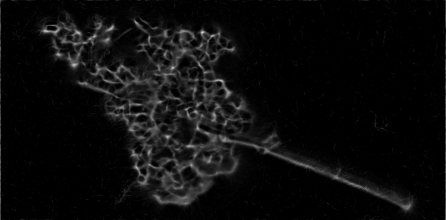

In [3]:
from phasepack import phasecong

PC_NSCALE=4
PC_NORIENT=6
PC_MIN_WAVELENGTH=2
PC_MULT=2.5
PC_SIGMA_ONF=0.55
PC_K=2.0
PC_CUTOFF=0.3
PC_G=5
PC_NOISEMETHOD=-1

def phasecong_Mm(roi):
    r = phasecong(roi,PC_NSCALE,PC_NORIENT,PC_MIN_WAVELENGTH,PC_MULT,PC_SIGMA_ONF,PC_K,PC_CUTOFF,PC_G,PC_NOISEMETHOD)

    M, m = r[0:2]

    return M + m

# use the sum of the first two images returned by phasecong3:
# 1. The maximum moment of phase congruency covariance; indicates edges
# 2. The minimum moment of phase congruency covariance; indicates corners
Mm = phasecong_Mm(roi)

show_image(Mm)

Step 2: Perform hysteresis thresholding of the edge image. Hysteresis thresholding is a recursive algorithm that is used to extend edges detected in previous iterations using a combination of binary dilation and ordinary thresholding.

/home/main/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
/home/main/anaconda2/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: /tmp/tmpXlWYjT.png is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


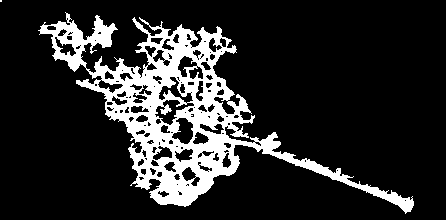

In [4]:
import numpy as np
from skimage.morphology import binary_dilation

EIGHT = np.ones((3,3)).astype(np.bool)

def hysthresh(img,T1,T2):
    """hysteresis thresholding"""
    """All pixels with values above T1 are marked as edges.
    All pixels adjacent to points that have been marked as edges
    and with values above T2 are also marked as edges. Eight-
    connectivity is used.
    Adapted from Peter Kovesi"""
    T2,T1 = sorted([T1,T2])
    edges = img > T1
    sum = 1
    while sum > 0:
        bd = (binary_dilation(edges,EIGHT) & (img > T2)) - edges
        edges |= bd
        sum = np.sum(bd)
    return edges

HT_T1, HT_T2 = 0.2, 0.1

H = hysthresh(Mm,HT_T1,HT_T2)

# trim pixels off border
H[H[:,1]==0,0]=0
H[H[:,-2]==0,-1]=0
H[0,H[1,:]==0]=0
H[-1,H[-2,:]==0]=0
    
show_mask(H)

Step 3: Add areas of the ROI that are dark to the edge image to produce a putative segmentation. Dark areas are detecting using K-means with k=2, and the threshold used to determine which pixels are dark is an adjusted mean of the two means produced by K-means.

/home/main/anaconda2/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: /tmp/tmpTtb_4y.png is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


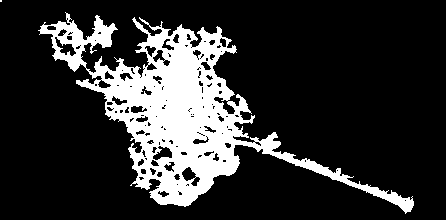

In [6]:
from scipy.cluster.vq import kmeans2

DARK_THRESHOLD_ADJUSTMENT=0.65

def dark_threshold(roi,adj=DARK_THRESHOLD_ADJUSTMENT):
    samples = roi.reshape((roi.size, 1)).astype(np.float)
    means, _ = kmeans2(samples,k=2)
    thresh = np.mean(means)
    return roi < thresh * DARK_THRESHOLD_ADJUSTMENT

dark = dark_threshold(roi)
D = H | dark

show_mask(D)

Step 3: Perform morphological closing and dilation to close up gaps within and along the edge of the segmentation.

/home/main/anaconda2/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: /tmp/tmpfFzXmg.png is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


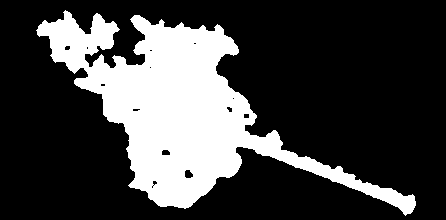

In [7]:
from skimage.morphology import binary_closing, binary_dilation

# kernels
SE2 = np.array([[0, 0, 1, 0, 0],
                [0, 1, 1, 1, 0],
                [1, 1, 1, 1, 1],
                [0, 1, 1, 1, 0],
                [0, 0, 1, 0, 0]], dtype=np.bool)
SE3 = np.ones((5,5),dtype=np.bool)

CD = binary_closing(D,SE3)
CD = binary_dilation(CD,SE2)

show_mask(CD)

Step 4: Perform morphological thinning of the segmentation using an algorithm described in

Z. Guo and R. W. Hall, "Parallel thinning with two-subiteration algorithms," Comm. ACM, vol. 32, no. 3, pp. 359-373, 1989.

/home/main/anaconda2/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: /tmp/tmpvCM2ZK.png is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


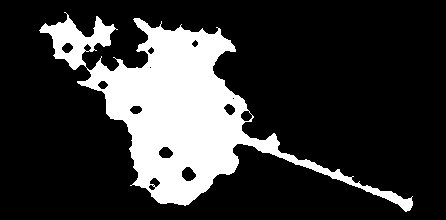

In [8]:
from scipy.ndimage import correlate

"""This optimized implementation is based on precomputed lookup tables,
and so is rather opaque; see the paper for details on the algorithm"""

G123_LUT = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0], dtype=np.bool)

G123P_LUT = np.array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=np.bool)

def bwmorph_thin(B, n_iter=1):
    mask = np.array([[ 8,  4,  2],
                     [16,  0,  1],
                     [32, 64,128]],dtype=np.uint8)
    skel = np.array(B).astype(np.bool).astype(np.uint8)
    for n in range(n_iter):
        for lut in [G123_LUT, G123P_LUT]:
            N = correlate(skel, mask, mode='constant')
            D = np.take(lut,N)
            skel[D]=0
    return skel.astype(np.bool)

T = bwmorph_thin(CD,3)

show_mask(T)

Step 5: Fill any gaps that are enclosed in the segmentation

/home/main/anaconda2/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: /tmp/tmp35qgbQ.png is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


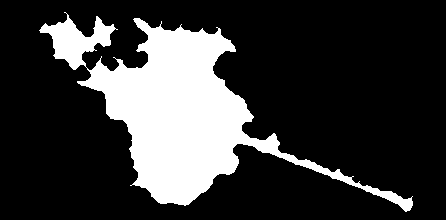

In [9]:
from scipy.ndimage.morphology import binary_fill_holes

FH = binary_fill_holes(T)

show_mask(FH)

Step 6: Remove objects below a certain size. These often result from artifacts and other non-significant features of the image.

/home/main/anaconda2/lib/python2.7/site-packages/skimage/morphology/misc.py:119: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warnings.warn("Only one label was provided to `remove_small_objects`. "
/home/main/anaconda2/lib/python2.7/site-packages/skimage/io/_io.py:159: UserWarning: /tmp/tmpROrERb.png is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


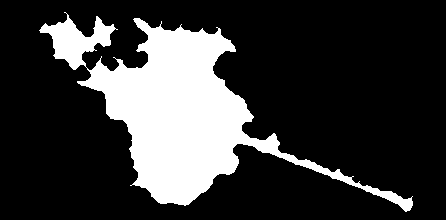

In [10]:
from skimage.morphology import remove_small_objects

BLOB_MIN = 150

B = remove_small_objects(FH,BLOB_MIN,connectivity=2)

show_mask(B)